# Analísis


In [28]:
import os
import re
from glob import glob
from datetime import datetime
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks
import folium
from folium.raster_layers import ImageOverlay
from rasterio.plot import reshape_as_image


Conteo de imágenes por lago:

- amatitlan: 363
- atitlan: 363

TOTAL imágenes: 726


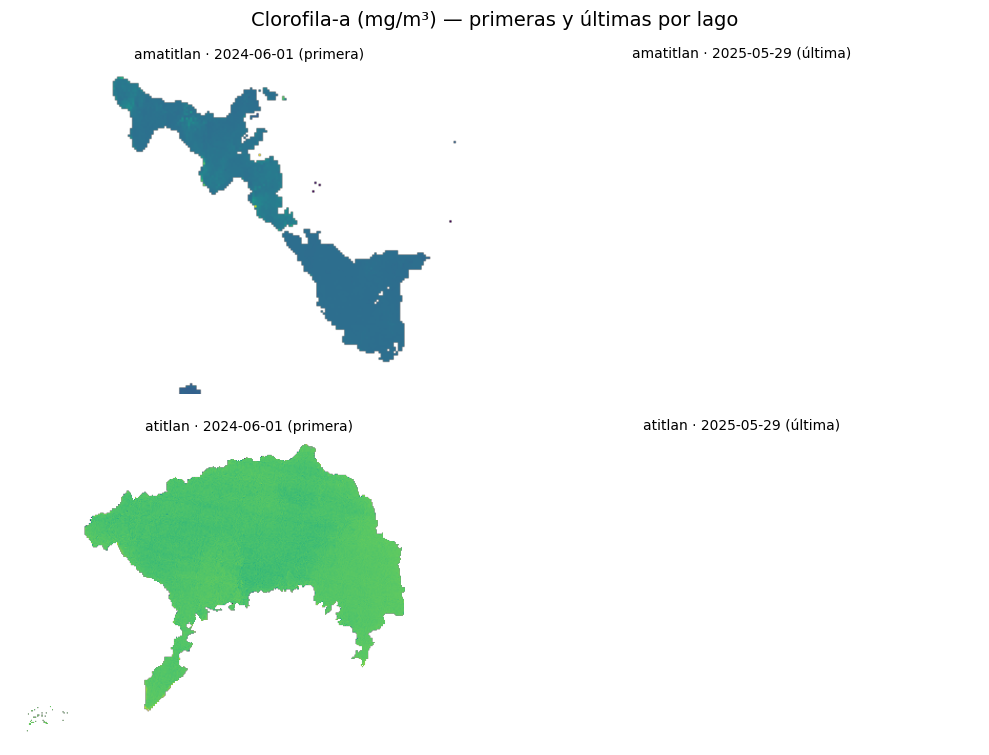

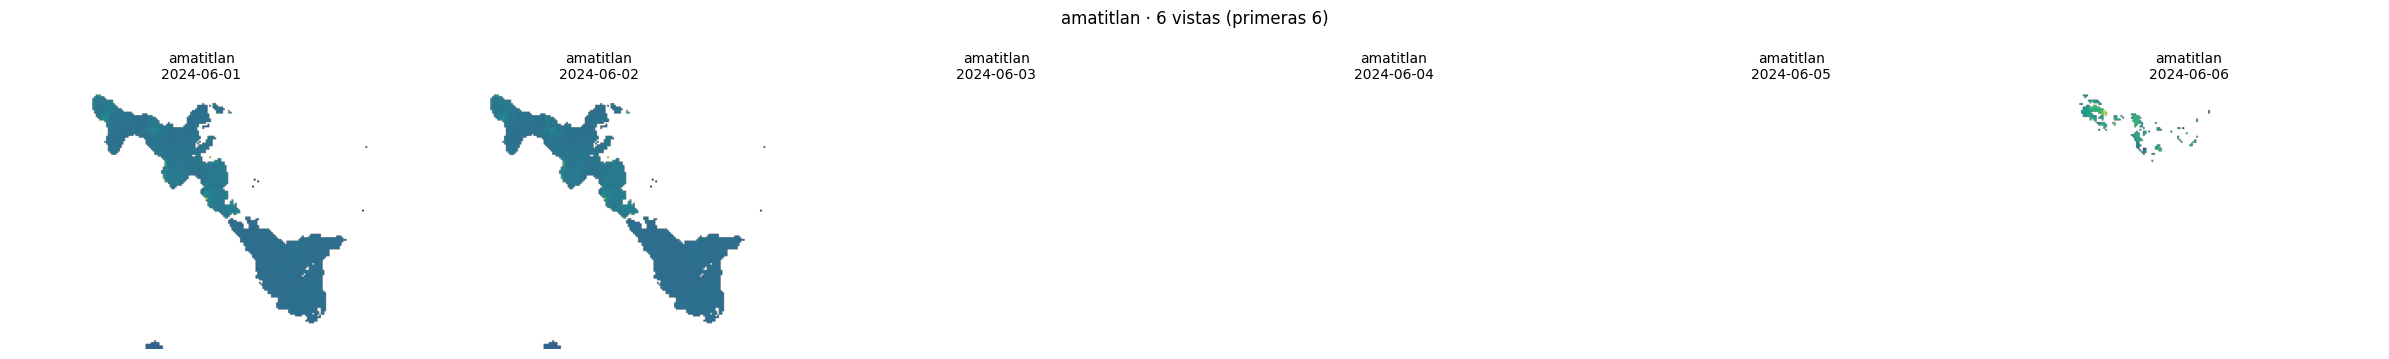

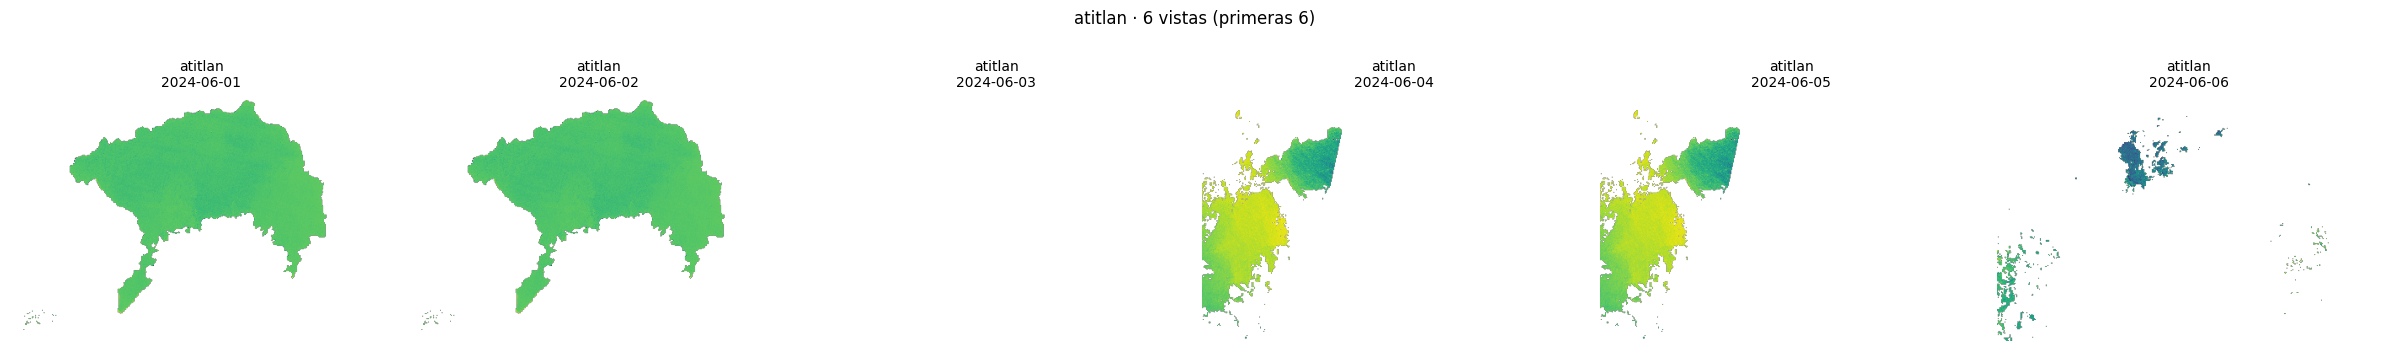

In [ ]:
# Descubrir todos los chl.tif y agrupar por lago ===
base_dir = "out"
pattern = os.path.join(base_dir, "*_*", "chl.tif")  # out/DATE_lake/chl.tif
paths = sorted(glob(pattern))

# Extraer fecha y lago del nombre de carpeta: "YYYY-MM-DD_lake-slug"
rx = re.compile(r"(?P<date>\d{4}-\d{2}-\d{2})_(?P<lake>.+)$")

by_lake = {}
for p in paths:
    parent = os.path.basename(os.path.dirname(p))  # "YYYY-MM-DD_lake"
    m = rx.match(parent)
    if not m:
        continue
    date = datetime.strptime(m.group("date"), "%Y-%m-%d").date()
    lake = m.group("lake")
    by_lake.setdefault(lake, []).append((date, p))

# Ordenar por fecha dentro de cada lago
for lake in by_lake:
    by_lake[lake].sort(key=lambda x: x[0])

# === 2) Reporte de conteos ===
total = 0
print("Conteo de imágenes por lago:\n")
for lake, items in by_lake.items():
    print(f"- {lake}: {len(items)}")
    total += len(items)
print(f"\nTOTAL imágenes: {total}")

# Si no hay nada, salir
if total == 0:
    raise SystemExit("No se encontraron archivos chl.tif con el patrón esperado.")

# Función para cargar y mostrar una imagen chl.tif ===
def show_chl(path, ax=None, title=None):
    with rasterio.open(path) as src:
        arr = src.read(1)  # banda única
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(arr, cmap="viridis")
    ax.set_axis_off()
    if title:
        ax.set_title(title, fontsize=10)
    return im

#  Visualización rápida: 1ra y última imagen por lago ===
n_lakes = len(by_lake)
fig, axes = plt.subplots(n_lakes, 2, figsize=(10, 4*n_lakes))
if n_lakes == 1:
    axes = np.array([axes])  # normaliza a 2D
    
for row, (lake, items) in enumerate(sorted(by_lake.items())):
    first_date, first_path = items[0]
    last_date,  last_path  = items[-1]

    im1 = show_chl(first_path, ax=axes[row, 0], title=f"{lake} · {first_date} (primera)")
    im2 = show_chl(last_path,  ax=axes[row, 1], title=f"{lake} · {last_date} (última)")

fig.suptitle("Clorofila-a (mg/m³) — primeras y últimas por lago", fontsize=14)
plt.tight_layout()
plt.show()

#  (Opcional) Panel rápido de hasta 6 fechas por lago ===
# Útil para “ver la película” por encima
max_panels = 6
for lake, items in sorted(by_lake.items()):
    subset = items[:max_panels]  # primeras N (cambia a items[-max_panels:] para últimas)
    n = len(subset)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    for ax, (d, p) in zip(axes, subset):
        show_chl(p, ax=ax, title=f"{lake}\n{d}")
    fig.suptitle(f"{lake} · {n} vistas (primeras {n})", fontsize=12)
    plt.tight_layout()
    plt.show()


# Analsis temporarl, índice promedio (mensual) de cianobacteria y evolución temporal  

[amatitlan] 2024-06: 30 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2024-07: 31 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2024-08: 31 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2024-09: 30 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2024-10: 31 imgs -> promedio mensual en memoria (HxW=(153, 223))


C:\Users\josue\AppData\Local\Temp\ipykernel_28300\4189750276.py:29: RuntimeWarning: Mean of empty slice
  mean_arr = np.nanmean(stack, axis=0)        # (H, W), ignora NaN


[amatitlan] 2024-11: 30 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2024-12: 31 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2025-01: 31 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2025-02: 28 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2025-03: 31 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2025-04: 30 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2025-05: 29 imgs -> promedio mensual en memoria (HxW=(153, 223))
[atitlan] 2024-06: 30 imgs -> promedio mensual en memoria (HxW=(292, 455))
[amatitlan] 2025-04: 30 imgs -> promedio mensual en memoria (HxW=(153, 223))
[amatitlan] 2025-05: 29 imgs -> promedio mensual en memoria (HxW=(153, 223))
[atitlan] 2024-06: 30 imgs -> promedio mensual en memoria (HxW=(292, 455))
[atitlan] 2024-07: 31 imgs -> promedio mensual en memoria (HxW=(292, 455))
[atitlan] 2024-08: 31 imgs -> promedio mensual en memoria (HxW=(292, 455))
[atitla

C:\Users\josue\AppData\Local\Temp\ipykernel_28300\4189750276.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


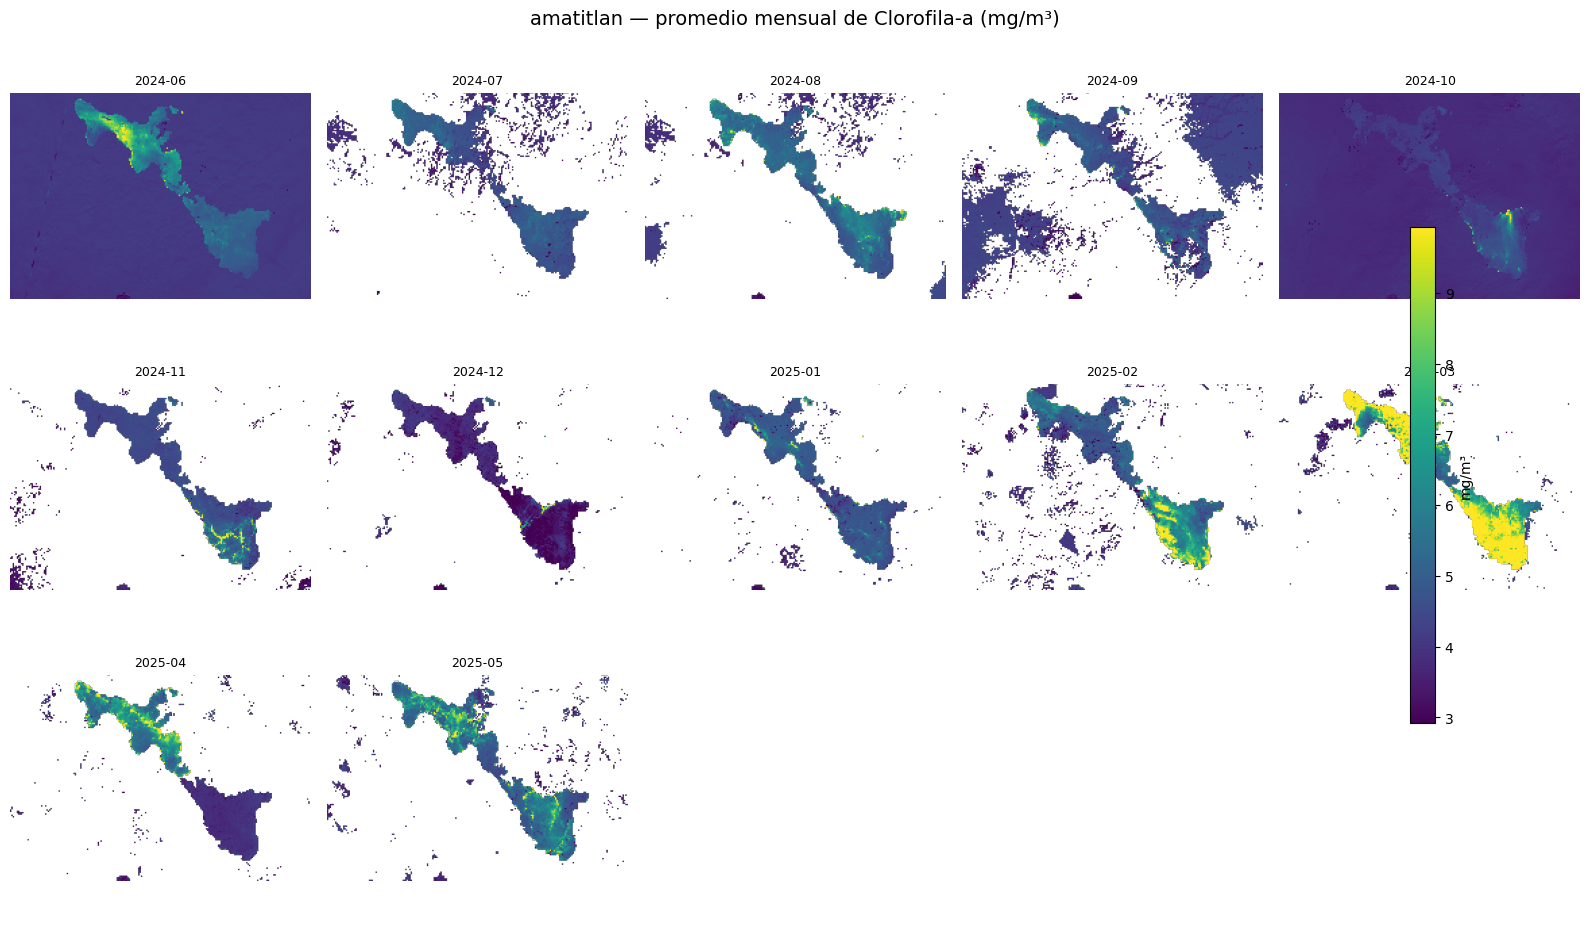

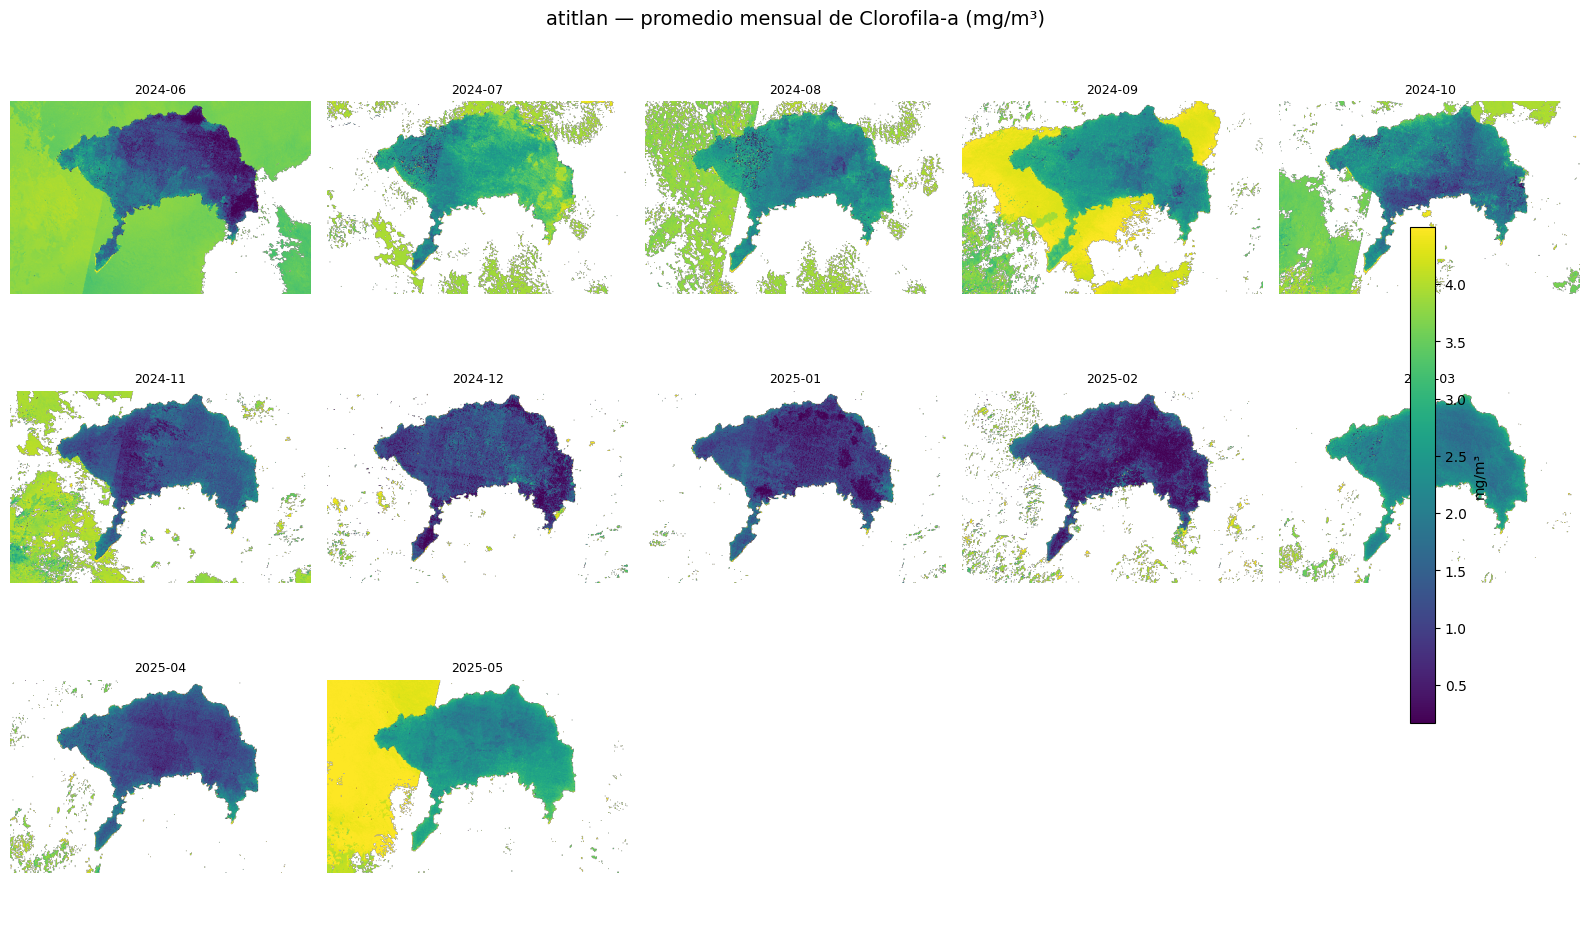

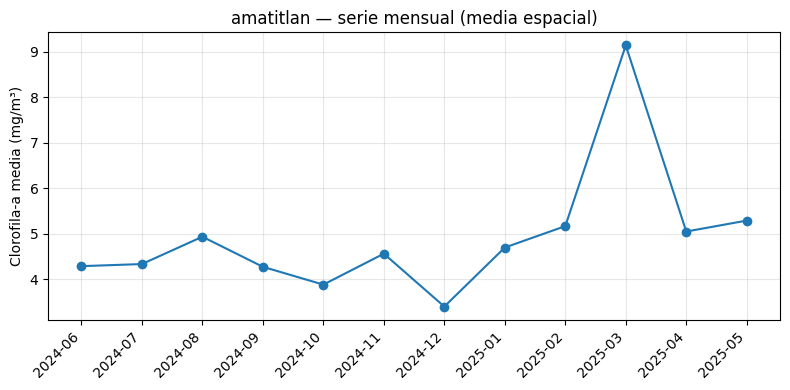

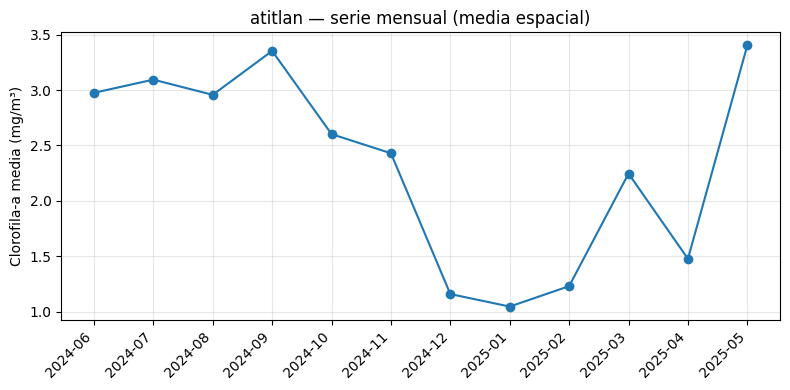

In [ ]:
import os
from collections import defaultdict
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pandas as pd

# === Agrupar por mes (YYYY-MM) dentro de cada lago ===
by_lake_month = defaultdict(lambda: defaultdict(list))  # {lake: {YYYY-MM: [(date, path), ...]}}
for lake, items in by_lake.items():
    for d, p in items:
        ym = f"{d.year:04d}-{d.month:02d}"
        by_lake_month[lake][ym].append((d, p))

# Función: promedio mensual por píxel (en memoria) ===
def monthly_mean_stack(paths):
    """Carga una lista de chl.tif y devuelve mean_arr (HxW float32) y meta_base (para info) usando nanmean."""
    arrays = []
    meta_base = None
    for path in paths:
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)
            if meta_base is None:
                meta_base = src.meta.copy()
            arrays.append(arr)
    if not arrays:
        return None, None
    stack = np.stack(arrays, axis=0)            # (N, H, W)
    mean_arr = np.nanmean(stack, axis=0)        # (H, W), ignora NaN
    return mean_arr, meta_base

# monthly_means: {lake: {ym: mean_arr}}
monthly_means = defaultdict(dict)
# También guardamos una media espacial por mes para gráfica temporal
monthly_stats = defaultdict(list)  # {lake: [{"ym":..., "chl_mean":...}, ...]}

for lake, month_dict in sorted(by_lake_month.items()):
    for ym, items in sorted(month_dict.items()):  # items: [(date, path), ...]
        month_paths = [p for _, p in items]
        mean_arr, meta = monthly_mean_stack(month_paths)
        if mean_arr is None:
            continue
        monthly_means[lake][ym] = mean_arr
        # media espacial ignorando NaN
        m = float(np.nanmean(mean_arr)) if np.isfinite(mean_arr).any() else np.nan
        monthly_stats[lake].append({"ym": ym, "chl_mean": m})
        print(f"[{lake}] {ym}: {len(month_paths)} imgs -> promedio mensual en memoria (HxW={mean_arr.shape})")

# Graficar progresión mensual por lago (sin guardar a disco) ===
for lake, month_map in sorted(monthly_means.items()):
    if not month_map:
        continue
    # Orden consistente por mes
    months_sorted = sorted(month_map.keys())
    arrays = [monthly_means[lake][ym] for ym in months_sorted]

    # Escala común por lago (mejor comparación): usar percentiles (2–98) para robustez
    all_vals = np.concatenate([a[np.isfinite(a)].ravel() for a in arrays if np.isfinite(a).any()])
    if all_vals.size > 0:
        vmin = float(np.percentile(all_vals, 2))
        vmax = float(np.percentile(all_vals, 98))
        if vmin >= vmax:  # fallback si degenera
            vmin, vmax = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))
    else:
        vmin, vmax = None, None

    n = len(months_sorted)
    cols = min(5, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.2))
    axes = np.array(axes).reshape(-1)

    last_im = None
    for ax, ym, arr in zip(axes, months_sorted, arrays):
        im = ax.imshow(arr, cmap="viridis", vmin=vmin, vmax=vmax)
        ax.set_title(ym, fontsize=9)
        ax.axis("off")
        last_im = im

    # Ejes sobrantes off
    for ax in axes[len(arrays):]:
        ax.axis("off")

    fig.suptitle(f"{lake} — promedio mensual de Clorofila-a (mg/m³)", fontsize=14)
    if last_im is not None:
        cbar = fig.colorbar(last_im, ax=axes.tolist(), fraction=0.02, pad=0.02)
        cbar.set_label("mg/m³")
    plt.tight_layout()
    plt.show()

# Serie temporal (media espacial por mes), sin archivos intermedios ===
for lake, recs in sorted(monthly_stats.items()):
    if not recs:
        continue
    df = pd.DataFrame(recs).sort_values("ym")
    plt.figure(figsize=(8, 4))
    plt.plot(df["ym"], df["chl_mean"], marker="o")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Clorofila-a media (mg/m³)")
    plt.title(f"{lake} — serie mensual (media espacial)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


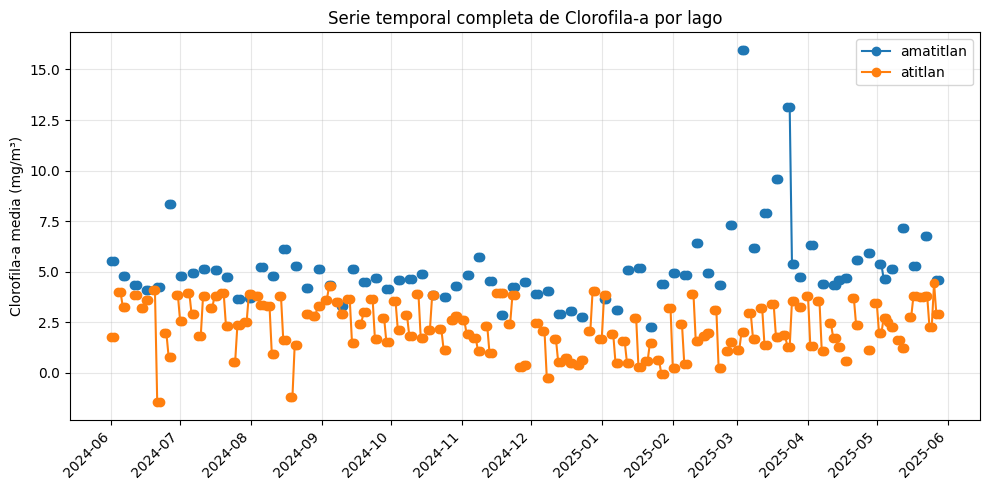

In [25]:
# Serie temporal completa: todas las fechas por lago ===
plt.figure(figsize=(10, 5))
for lake, items in sorted(by_lake.items()):
    # Para cada fecha, calcular la media espacial de la imagen
    dates = []
    means = []
    for d, p in items:
        with rasterio.open(p) as src:
            arr = src.read(1).astype(np.float32)
            m = float(np.nanmean(arr)) if np.isfinite(arr).any() else np.nan
            dates.append(d)
            means.append(m)
    plt.plot(dates, means, marker='o', label=lake)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Clorofila-a media (mg/m³)')
plt.title('Serie temporal completa de Clorofila-a por lago')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Picos de flora


Lago: amatitlan
No se detectaron picos de floración destacados.


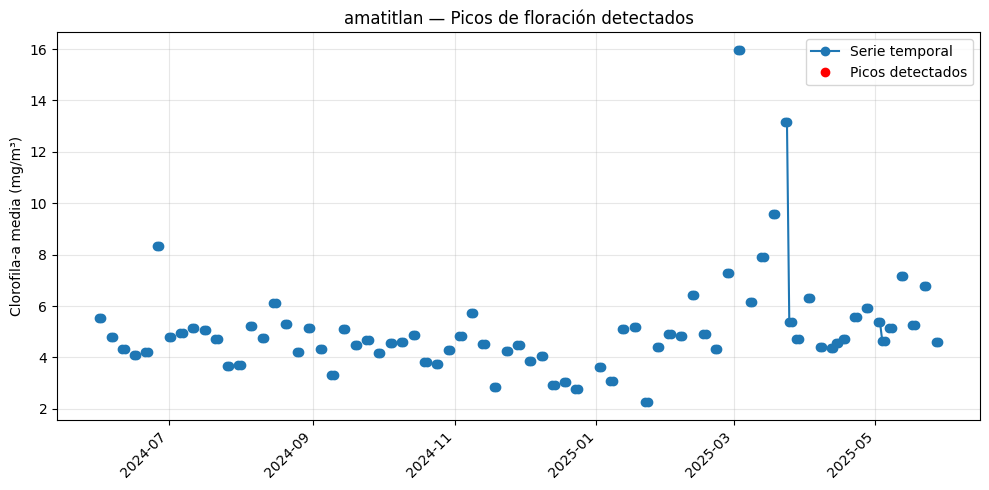


Lago: atitlan
No se detectaron picos de floración destacados.


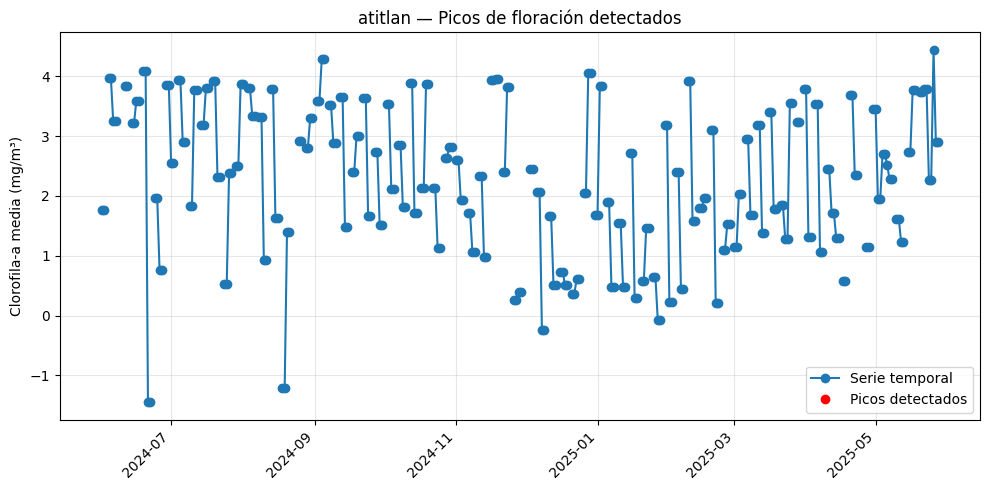

In [ ]:
# Parámetros para detección de picos (ajustables según el rango de datos)
peak_prominence = 5  # mg/m³, ajusta según tu dataset
peak_distance = 2    # mínimo separación en número de observaciones


for lake, items in sorted(by_lake.items()):
    dates = []
    means = []
    for d, p in items:
        with rasterio.open(p) as src:
            arr = src.read(1).astype(np.float32)
            m = float(np.nanmean(arr)) if np.isfinite(arr).any() else np.nan
            dates.append(d)
            means.append(m)
    means_arr = np.array(means)
    # Detección de picos
    peaks, props = find_peaks(means_arr, prominence=peak_prominence, distance=peak_distance)
    print(f'\nLago: {lake}')
    if len(peaks) == 0:
        print('No se detectaron picos de floración destacados.')
    else:
        print(f'Se detectaron {len(peaks)} picos de floración:')
        for idx in peaks:
            print(f'  - Fecha crítica: {dates[idx]} | Clorofila-a media: {means_arr[idx]:.2f} mg/m³')
    # Opcional: graficar con picos resaltados
    plt.figure(figsize=(10, 5))
    plt.plot(dates, means_arr, marker='o', label='Serie temporal')
    plt.plot([dates[i] for i in peaks], means_arr[peaks], 'ro', label='Picos detectados')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Clorofila-a media (mg/m³)')
    plt.title(f'{lake} — Picos de floración detectados')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Aunque el algoritmo no haya marcado “picos” formales según el umbral configurado, los gráficos muestran patrones que permiten sacar conclusiones cualitativas:

Lago Amatitlán: la mayor parte del tiempo la clorofila-a media se mantiene estable entre ~3 y 6 mg/m³, pero hay al menos un evento muy sobresaliente a inicios de marzo de 2025 que supera los 16 mg/m³, seguido de una caída rápida. Esto sugiere un episodio aislado de floración intensa que quizá no fue detectado por el criterio de picos debido a la configuración de sensibilidad.

Lago Atitlán: las concentraciones son menores (~0 a 4 mg/m³) y más variables día a día, con descensos abruptos y recuperaciones rápidas. No se observan valores tan altos como en Amatitlán, pero sí una fluctuación constante que podría enmascarar picos moderados. También se nota una ligera tendencia a valores algo más bajos en el período noviembre 2024 – febrero 2025, seguida de una recuperación.

# Analisis espacial
Mapea la distribución de cianobacteria dentro de cada lago.
mapas comparativos entre diferentes fechas para cada lago

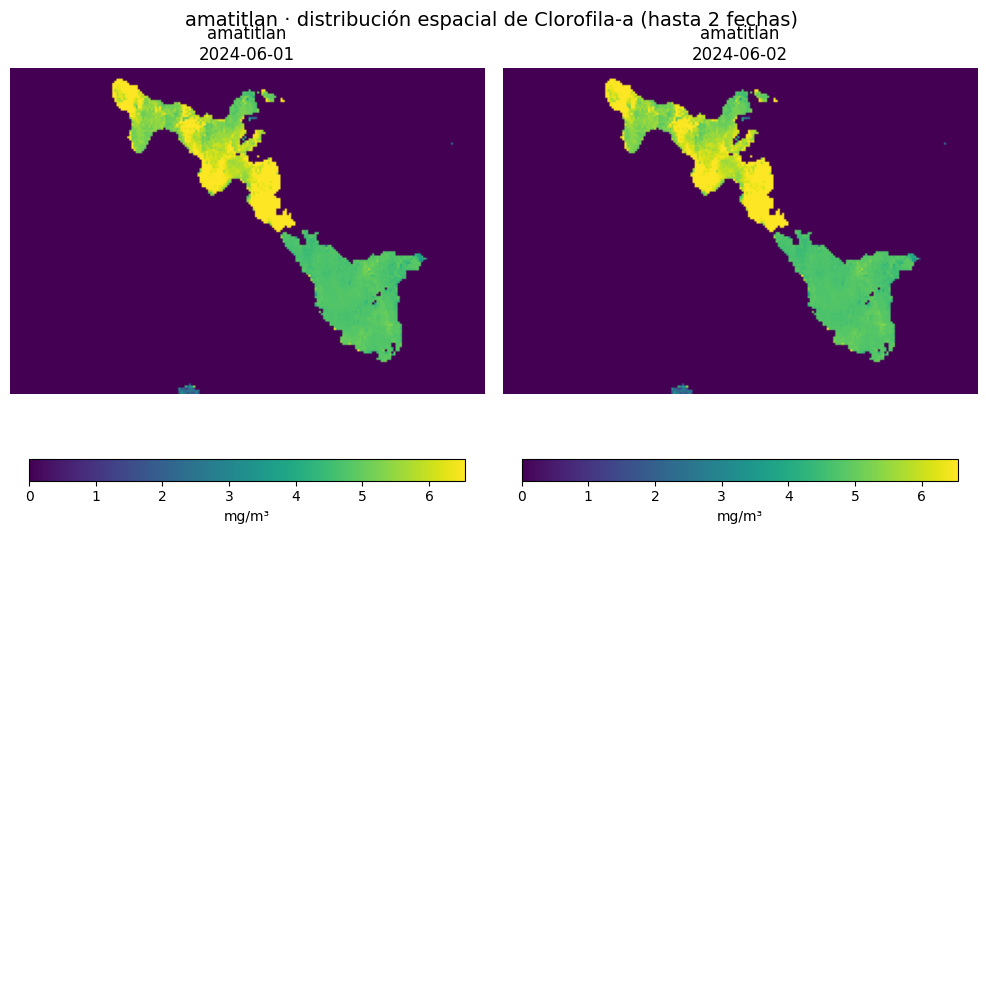

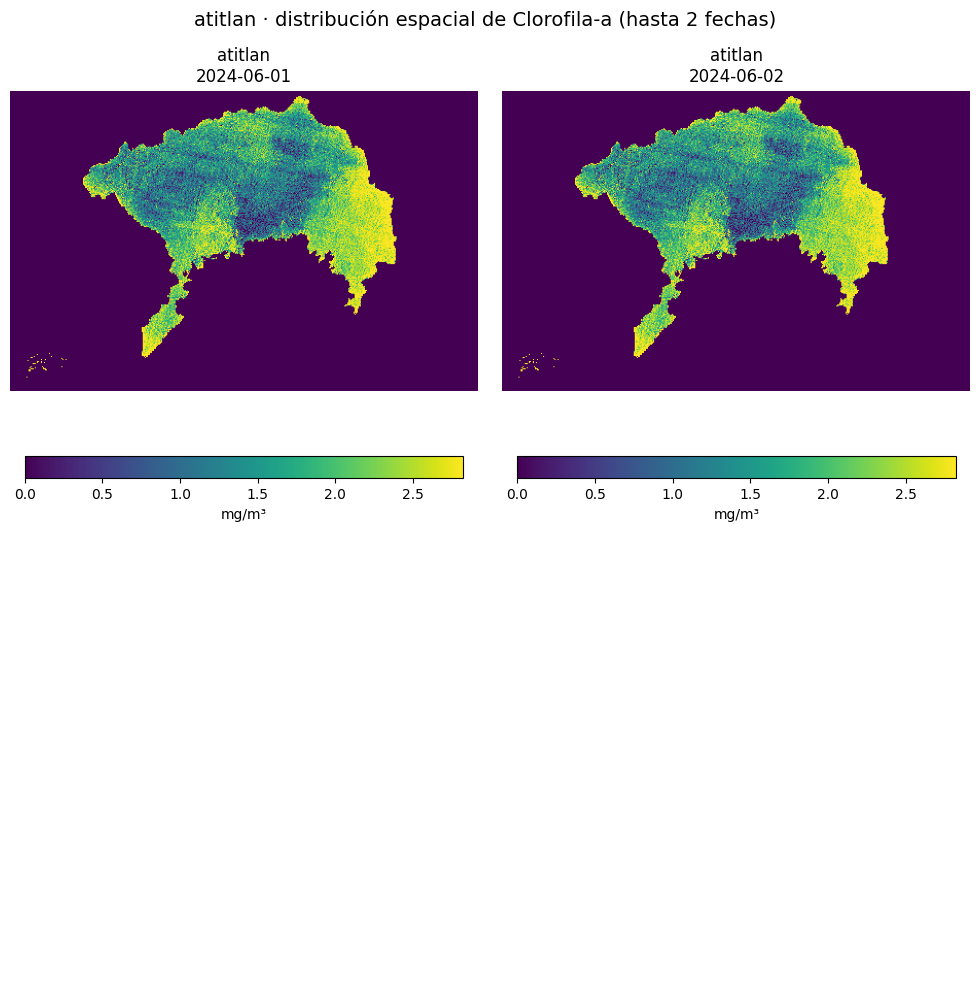

In [64]:
max_compare = 2  # hasta 4 fechas por lago
for lake, items in sorted(by_lake.items()):
    subset = items[:max_compare]
    n = len(subset)
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()
    for i, (d, p) in enumerate(subset):
        ax = axes[i]
        with rasterio.open(p) as src:
            arr = src.read(1)
            arr = np.nan_to_num(arr, nan=0)
            vmin = np.nanpercentile(arr, 2)
            vmax = np.nanpercentile(arr, 98)
            im = ax.imshow(arr, cmap='viridis', vmin=vmin, vmax=vmax)
            ax.set_title(f'{lake}\n{d}')
            ax.axis('off')
            cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
            cbar.set_label('mg/m³')
    # Ejes sobrantes off
    for j in range(n, rows*cols):
        axes[j].axis('off')
    fig.suptitle(f'{lake} · distribución espacial de Clorofila-a (hasta 2 fechas)', fontsize=14)
    plt.tight_layout()
    plt.show()